### Import

#### Local

In [1]:
from pathlib import PosixPath

root = PosixPath('/mnt/188f6bc0-7ce9-4833-a30f-60f6ee8c4aef/Project')

#### Colab

In [2]:
# from google.colab import drive
# from pathlib import PosixPath


# drive.mount('/content/drive')
# root = PosixPath('/content/drive/My Drive/DS/')


In [3]:
import sys

sys.path.append(str(root/'lib'))

In [4]:
from xml.dom import minidom
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.upsampling import Upsample
import cv2
from PIL import Image
from tqdm.autonotebook import tqdm
from ssd import ssd_loss
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset, DataLoader
from os.path import isfile
from joblib import dump, load
from functools import partial
from fastai.train import clip_grad
from torchvision import transforms
from ssd import SSD
from fastai.vision import *
import imagesize

/home/hvlpr/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### VOC read

In [5]:
path = root/'yolo'
voc_path = path/'voc/VOCdevkit/VOC2012/'
images_path = voc_path/'JPEGImages'
anno_path = voc_path/'Annotations'

In [6]:
images_data = {}

In [7]:
# for anno in anno_path.iterdir():
    
#     boxes = []
#     classes = []
#     with minidom.parse(str(anno)) as xmldoc:
#         filename = xmldoc.getElementsByTagName('filename')[0].childNodes[0].data
#         bndboxes = xmldoc.getElementsByTagName('bndbox')
#         names = xmldoc.getElementsByTagName('name')
#         for i in range(len(bndboxes)):
#             bndbox = bndboxes[i]
#             xmin = bndbox.getElementsByTagName('xmin')[0].childNodes[0].data
#             xmax = bndbox.getElementsByTagName('xmax')[0].childNodes[0].data
#             ymin = bndbox.getElementsByTagName('ymin')[0].childNodes[0].data
#             ymax = bndbox.getElementsByTagName('ymax')[0].childNodes[0].data
#             box = [ymin, xmin, ymax, xmax]
#             boxes.append(box)
#             name = names[i].childNodes[0].data
#             classes.append(name)
#         images_data[filename] = [boxes, classes]
    
    

In [8]:
# dict_data = images_data

In [9]:
# classes = list(set([i for x in images_data.values() for i in x[1]]))

In [10]:
# classes_dict = {x: index for index, x in enumerate(classes)}
# classes_dict['background'] = len(classes_dict)

In [11]:
# index_dict = {val: key for key, val in classes_dict.items()}

In [12]:
# index_dict[len(index_dict)] = 'background'

In [13]:
# for key in dict_data:
#     val = dict_data[key]
# #     val[1] = [index_dict.get(x, classes_dict.get(x, index_dict.get(x))) for x in val[1]]
#     val[0] = [[float(v) for v in box] for box in val[0]]

In [14]:
# classes_dict['background'] = len(classes_dict)

In [15]:
# dump(dict_data, voc_path/'data.pkl')

# dump(classes_dict, voc_path/'dict.pkl')

dict_data = load(voc_path/'data.pkl')
classes_dict = load(voc_path/'dict.pkl')


### Parameters

In [16]:
NBOXES = 3
N_CLASSES = len(classes_dict)
FEATURES = NBOXES*(5 + N_CLASSES)

TX = 0
TY = 1
TW = 2
TH = 3
CONF = 4
bs = 8


IMAGE_GRID = 26
IMAGE_SIZE = 300# 416 ## 
# label = [bouding box, (5), 26, 26]
BOX_SIZDE = IMAGE_SIZE / IMAGE_GRID
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOSS_REDUCTION = 'sum'

### Data

#### Data

In [17]:
def roundboxes(boxes):
    return [[[b[1], b[0], b[1] + b[3], b[0] + b[2]] for b in boxes], ['face']*len(boxes)]

def emptyboxes():
    return [[[0, 0, 0, 0]], ['background']]

In [18]:
def label_func(x):
    x = PosixPath(x).name
    return dict_data.get(x, emptyboxes())

In [19]:
train_df = pd.DataFrame({'name': list(dict_data.keys())})

In [20]:
data = ObjectItemList.from_df(train_df, path=images_path).split_by_rand_pct()
pad_collate = partial(bb_pad_collate, pad_idx='background')

In [21]:
data = data.label_from_func(label_func)\
.transform(get_transforms(), size=IMAGE_SIZE, tfm_y=True)\
.databunch(bs=bs, val_bs=bs*2, collate_fn=bb_pad_collate)


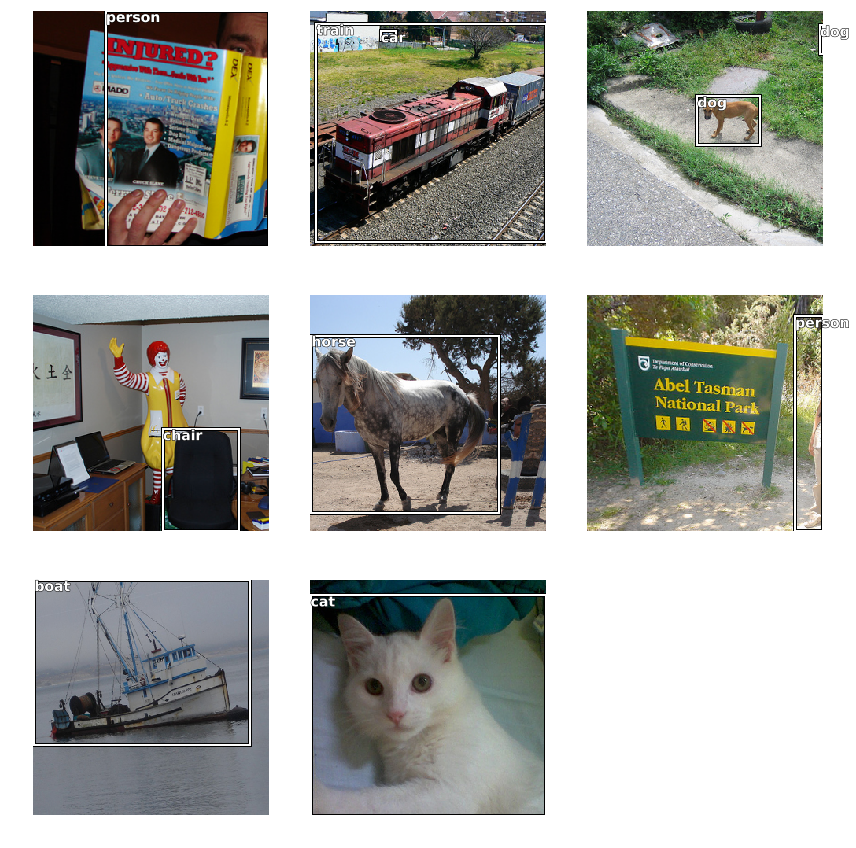

In [22]:
data.show_batch(11)

In [23]:
# data.save(voc_path/'data.bin')

### Test

In [ ]:
batch = next(iter(data.train_dl))

In [ ]:
batch[1][1].shape

torch.Size([8, 3])

In [ ]:
batch_sample = 2
image = batch[0][batch_sample]
boxes = batch[1][0][batch_sample]

In [ ]:
boxes = np.array([[-0.6910, -1.0000,  0.8046,  0.8126], [-0.0524, -0.5271,  0.4435, -0.3555], [-0.7457, -1.0000,  0.3988, -0.3220]])
boxes = (boxes + 1)*(IMAGE_SIZE/2)
boxes = [[x, y, w - x, h - y] for [y, x, h, w] in boxes]

In [ ]:
np_image = image.permute(1, 2, 0).cpu().numpy()

(0, 46) (272, 270)
(71, 142) (97, 216)
(0, 38) (102, 210)


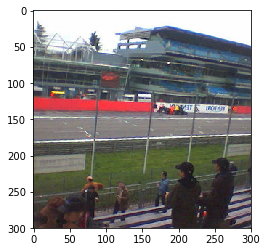

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create a Rectangle patch
for cord in boxes:
    [x, y, w, h] = [int(round(a)) for a in cord]
    print((x,y), (x+w,y+h))
    cv2.rectangle((np_image*255).astype('int32'), (x,y), (x+w,y+h), (0,255,0), 10)

# Display the image
plt.imshow(np_image)



plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0, 46) (272, 270)
(71, 142) (97, 216)
(0, 38) (102, 210)


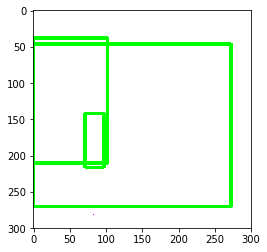

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create a Rectangle patch
for cord in boxes:
    [x, y, w, h] = [int(round(a)) for a in cord]
    print((x,y), (x+w,y+h))
    np_image = cv2.rectangle((np_image*255).astype('int32'), (x,y), (x+w,y+h), (0,255,0), 3)

# Display the image
plt.imshow(np_image)



plt.show()

### Feed

In [ ]:
from ssd import MobileNetSSD

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

net = MobileNetSSD(N_CLASSES).to(device)

- Forward to calculate $(g_{c_x}, g_{c_y}, g_w, g_h)$
- Identify corresponding prior $(\hat{c}_x, \hat{c}_y, \hat{w}, \hat{h})$
- Calculate Predicted box 
    - $c_x = g_{c_x}*\hat{w} + \hat{c}_x$
    - $c_y = g_{c_y}*\hat{h} + \hat{c}_y$
    - $w = e^{g_{w}}*\hat{w}$
    - $h = e^{g_{h}}*\hat{h}$
- Calculate IoU
- Match

- Create overlapping table between predicted and ground truth (8732*number of ground truth object)
- Match each priors with greatest overlap
- Categorize as positive and negative match
- Calculate loss

### Loss

In [ ]:
eps = 1e-3
ssd_loss = partial(ssd_loss, device=device, im_size=IMAGE_SIZE, eps=eps)

In [ ]:
loss = partial(ssd_loss, n_classes=N_CLASSES, smoothl1=nn.SmoothL1Loss(reduction='sum'), cre=nn.CrossEntropyLoss(reduction='sum'))

In [ ]:
opt = partial(torch.optim.SGD, lr=1e-3, momentum=0.9, weight_decay=0.0005)

In [ ]:
learn = Learner(data, net, loss_func=loss, opt_func=opt)
learn = clip_grad(learn, clip=1)

In [ ]:
learn.load(path/'mobile_weight_{}.bin'.format(0))

Learner(data=ImageDataBunch;

Train: LabelList (13700 items)
x: ObjectItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: ObjectCategoryList
ImageBBox (300, 300),ImageBBox (300, 300),ImageBBox (300, 300),ImageBBox (300, 300),ImageBBox (300, 300)
Path: /mnt/188f6bc0-7ce9-4833-a30f-60f6ee8c4aef/Project/yolo/voc/VOCdevkit/VOC2012/JPEGImages;

Valid: LabelList (3425 items)
x: ObjectItemList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: ObjectCategoryList
ImageBBox (300, 300),ImageBBox (300, 300),ImageBBox (300, 300),ImageBBox (300, 300),ImageBBox (300, 300)
Path: /mnt/188f6bc0-7ce9-4833-a30f-60f6ee8c4aef/Project/yolo/voc/VOCdevkit/VOC2012/JPEGImages;

Test: None, model=MobileNetSSD(
  (fm1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affin

In [ ]:
# learn.lr_find(wd=0.0005)

In [ ]:
# learn.recorder.plot()

In [ ]:
for i in range(20):
    learn.fit(1, lr=1e-3, wd=0.0005) # 9500
    learn.save(path/'mobile_weight_{}.bin'.format(i))

epoch,train_loss,valid_loss,time


### Inference

In [ ]:
test_path = PosixPath('/content/drive/My Drive/DS/yolo/WIDER_test/images')
test_data = []
for label in os.listdir(test_path):
    for file in os.listdir(test_path/label):
        test_data.append(label + '/' + file)


import random

random.shuffle(test_data)
sample_test_data = test_data[:32]
sample_test_data = [PIL.Image.open(test_path/x) for x in sample_test_data]

In [ ]:
sample_test_data = [train_tfms(x) for x in sample_test_data]

In [ ]:
sample_test_data = torch.cat([x[None, ...] for x in sample_test_data], dim=0)

In [ ]:
sample_test_data = sample_test_data.to(device)

In [ ]:
with torch.no_grad():
    out = learn.model(sample_test_data)

In [ ]:
out26 = out[1]

In [ ]:
boxes = label2box(out26)

In [ ]:
boxes[0]

In [ ]:
out26[:, :, CONF, 0, 0]